In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [27]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from albumentations.core.transforms_interface import ImageOnlyTransform

In [53]:
def _gf(x, add_g=True):
    const_g = 6.67259 * 1e-11 if add_g else 1.
    x = x.flatten(1)
    # remove center point
    i_center= x.size(-1) // 2

    center = x[:, i_center]
    nb = torch.cat([x[:, :i_center], x[:,i_center+1:]], dim=1) # neighbours

    # trig
#     up_trig = torch.from_numpy(np.arange(1,4)[::-1] * .25 * np.pi)
#     mid_trig = torch.from_numpy(np.array([4.0, 0.0]) * .25 * np.pi)
#     bot_trig = torch.from_numpy(np.arange(-3, 0) * .25 * np.pi)
    
    bot_trig = torch.from_numpy(np.arange(1,4) * .25 * np.pi)
    mid_trig = torch.from_numpy(np.array([4.0, 0.0])[::-1] * .25 * np.pi)
    up_trig = torch.from_numpy(np.arange(-3, 0)[::-1] * .25 * np.pi)
    trig = torch.cat([up_trig, mid_trig, bot_trig])
    

    # euclidean distance
#     distance = torch.sqrt((nb - center[:, None])**2) ** 2
    distance = torch.sqrt((torch.tensor([0., 1., 2., 3., 5., 6., 7., 8.]) - torch.tensor([4.])) ** 2)

    gf_x = const_g * torch.sum(((center[:, None] * nb) / distance) * torch.sin(trig) , axis=1)
    gf_y = const_g * torch.sum(((center[:, None] * nb) / distance) * torch.cos(trig) , axis=1)
    
    return gf_x, gf_y

def gf_conv(features):
    kernel_size=3
    stride=1
    padding=1
    add_g=True
    
    features = F.pad(features, (padding,padding,padding,padding))
    out_f_M = torch.zeros(features.size(-3), (features.size(-2) - 3 + 1) // stride, (features.size(-1) - 3 + 1) // stride)
    out_f_D = torch.zeros_like(out_f_M)
    for i in range(0, features.size(-2) - kernel_size + 1, stride):
        for j in range(0, features.size(-1) - kernel_size + 1, stride):
            x = features[:, i:i+kernel_size, j:j+kernel_size]
            gf_x, gf_y = _gf(x, add_g)
            out_f_M[:,i,j] = torch.sqrt(gf_x**2 + gf_y**2)
            out_f_D[:,i,j] = torch.atan(gf_y / gf_x)
            
    return out_f_M

In [54]:
class GFConv(ImageOnlyTransform):
    def apply(self, img, **params):
        return gf_conv(torch.from_numpy(img))

In [55]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(image=X)['image']

#             X = torch.cat((X,X,X),0)

        return X, y

In [56]:
batch_size= 16

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


train_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(64,64),
    GFConv(),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, p=0.5, border_mode=0, value=0),
#     A.RandomCrop(height=40, width=40),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2(),
])


test_transforms = A.Compose([
#     A.CLAHE(),
    A.Resize(64,64),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2()
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
# val_loader = torch.utils.data.DataLoader(val_set,
#                                              batch_size=batch_size, shuffle=False,
#                                              num_workers=8)
# test_loader = torch.utils.data.DataLoader(test_set,
#                                              batch_size=batch_size, shuffle=False,
#                                              num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
images, labels = iter(train_loader).next()

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-55-cc86490abb55>", line 28, in __getitem__
    X = self.transforms(image=X)['image']
  File "/usr/local/lib/python3.6/dist-packages/albumentations/core/composition.py", line 182, in __call__
    data = t(force_apply=force_apply, **data)
  File "/usr/local/lib/python3.6/dist-packages/albumentations/core/transforms_interface.py", line 89, in __call__
    return self.apply_with_params(params, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/albumentations/core/transforms_interface.py", line 102, in apply_with_params
    res[key] = target_function(arg, **dict(params, **target_dependencies))
  File "<ipython-input-54-9e871ad50e17>", line 3, in apply
    return gf_conv(torch.from_numpy(img))
  File "<ipython-input-53-a498ec01cc1d>", line 37, in gf_conv
    out_f_M = torch.zeros(features.size(-3), (features.size(-2) - 3 + 1) // stride, (features.size(-1) - 3 + 1) // stride)
IndexError: Dimension out of range (expected to be in range of [-2, 1], but got -3)


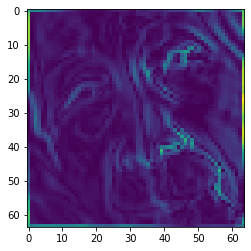

In [46]:
plt.imshow(images[1][0])